
           REGRESSION METRICS (Simple LR): sklearn vs From Scratch            
Metric      sklearn Train  Scratch Train  sklearn Test  Scratch Test
------------------------------------------------------------------------------
MSE              0.000433       0.000433      0.000409      0.000409
RMSE             0.020804       0.020804      0.020213      0.020213
MAE              0.014362       0.014362      0.014795      0.014795
R2               0.000287       0.000287      0.000807      0.000807

Scratch parameters:
b0 (intercept) = 0.0010696742
b1 (slope)     = -0.0169433749

Sklearn parameters:
intercept_ = 0.0010696742
coef_      = -0.0169433749


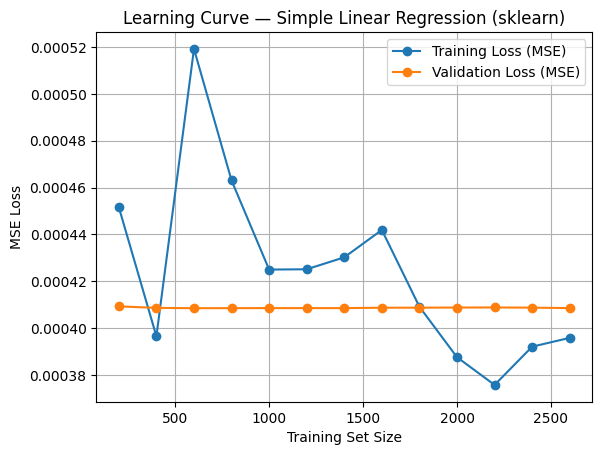

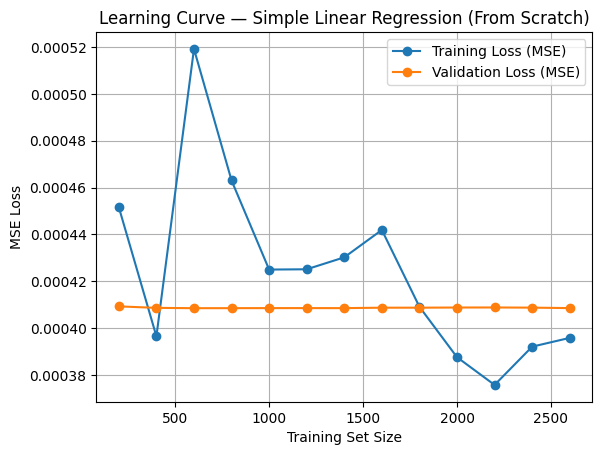

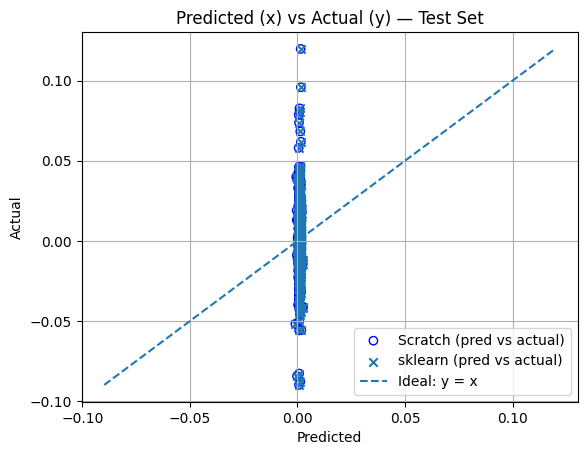

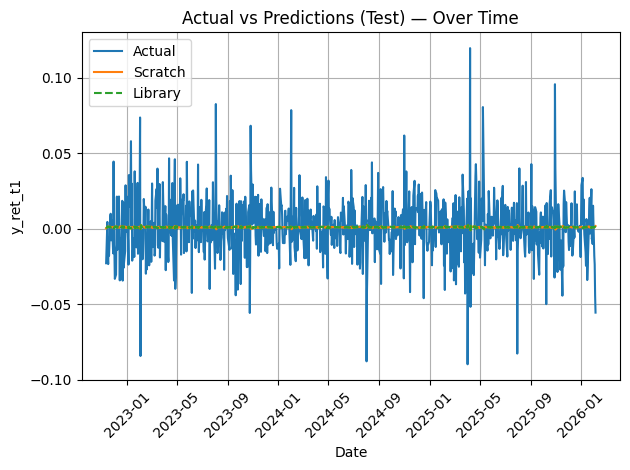

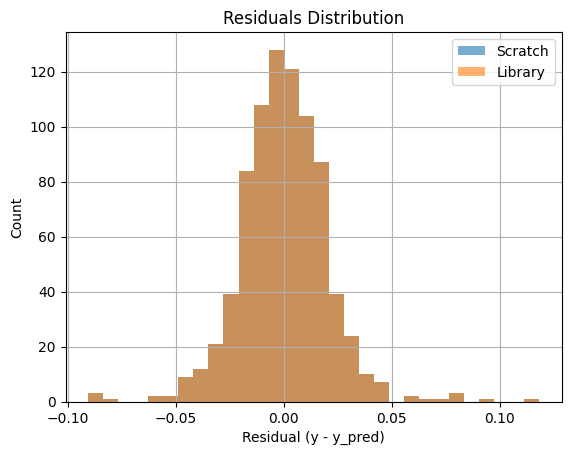

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# =============================
# CONFIG
# =============================
CSV_PATH = "../SnP_daily_update_AMZN_features_with_target.csv"
DATE_COL = "Date"
X_COL = "ret_1"
Y_COL = "y_ret_t1"

TRAIN_RATIO = 0.8
LC_TRAIN_SIZES = np.arange(200, 2601, 200)

# =============================
# Helpers
# =============================
def time_series_split(X, y, train_ratio=0.8):
    n = len(X)
    tr_end = int(n * train_ratio)
    return (X[:tr_end], y[:tr_end], X[tr_end:], y[tr_end:])

def metrics_dict(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {"MSE": mse, "RMSE": rmse, "MAE": mae, "R2": r2}

def print_metrics_table(title, sk_tr, sc_tr, sk_te, sc_te):
    print("\n" + "="*78)
    print(f"{title:^78}")
    print("="*78)
    print(f"{'Metric':<10} {'sklearn Train':>14} {'Scratch Train':>14} {'sklearn Test':>13} {'Scratch Test':>13}")
    print("-"*78)
    for k in ["MSE", "RMSE", "MAE", "R2"]:
        print(f"{k:<10} {sk_tr[k]:>14.6f} {sc_tr[k]:>14.6f} {sk_te[k]:>13.6f} {sc_te[k]:>13.6f}")
    print("="*78)

# =============================
# From-scratch Simple Linear Regression (OLS closed-form)
#   y = b0 + b1*x
# =============================
def fit_simple_lr_scratch(x_train_1d, y_train):
    x = x_train_1d.astype(np.float64)
    y = y_train.astype(np.float64)

    x_mean = x.mean()
    y_mean = y.mean()

    Sxx = np.sum((x - x_mean) ** 2)
    Sxy = np.sum((x - x_mean) * (y - y_mean))

    if Sxx == 0:  # กันเคส x คงที่
        b1 = 0.0
        b0 = y_mean
    else:
        b1 = Sxy / Sxx
        b0 = y_mean - b1 * x_mean

    return b0, b1

def predict_simple_lr(x_1d, b0, b1):
    return b0 + b1 * x_1d

# =============================
# Load + prepare data
# =============================
df = pd.read_csv(CSV_PATH)

df[DATE_COL] = pd.to_datetime(df[DATE_COL])
df = df.sort_values(DATE_COL).reset_index(drop=True)

data = df[[DATE_COL, X_COL, Y_COL]].dropna().copy()
dates_all = data[DATE_COL].to_numpy()    
x_all = data[X_COL].to_numpy(dtype=np.float64)
y_all = data[Y_COL].to_numpy(dtype=np.float64)

# Split time-series
x_train, y_train, x_test, y_test = time_series_split(x_all, y_all, TRAIN_RATIO)

# =============================
# 1) scikit-learn Simple Linear Regression
# =============================
sk_model = LinearRegression()
sk_model.fit(x_train.reshape(-1, 1), y_train)

sk_pred_train = sk_model.predict(x_train.reshape(-1, 1))
sk_pred_test  = sk_model.predict(x_test.reshape(-1, 1))

# =============================
# 2) Scratch Simple Linear Regression
# =============================
b0, b1 = fit_simple_lr_scratch(x_train, y_train)

sc_pred_train = predict_simple_lr(x_train, b0, b1)
sc_pred_test  = predict_simple_lr(x_test,  b0, b1)

# =============================
# Metrics table
# =============================
sk_tr = metrics_dict(y_train, sk_pred_train)
sc_tr = metrics_dict(y_train, sc_pred_train)
sk_te = metrics_dict(y_test,  sk_pred_test)
sc_te = metrics_dict(y_test,  sc_pred_test)

print_metrics_table("REGRESSION METRICS (Simple LR): sklearn vs From Scratch", sk_tr, sc_tr, sk_te, sc_te)

print("\nScratch parameters:")
print(f"b0 (intercept) = {b0:.10f}")
print(f"b1 (slope)     = {b1:.10f}")
print("\nSklearn parameters:")
print(f"intercept_ = {sk_model.intercept_:.10f}")
print(f"coef_      = {sk_model.coef_[0]:.10f}")

# =============================
# Plot 1: Learning Curve (Train/Val MSE)
# =============================
train_mse_sk, val_mse_sk = [], []
train_mse_sc, val_mse_sc = [], []

x_val, y_val = x_test, y_test  # ใช้ test เป็น validation ให้เหมือนที่คุณทำ

train_sizes_used = []
for m in LC_TRAIN_SIZES:
    m = int(m)
    if m < 10 or m > len(x_train):
        continue

    train_sizes_used.append(m)

    x_sub = x_train[:m]
    y_sub = y_train[:m]

    # sklearn
    mdl = LinearRegression()
    mdl.fit(x_sub.reshape(-1, 1), y_sub)

    y_sub_pred = mdl.predict(x_sub.reshape(-1, 1))
    y_val_pred = mdl.predict(x_val.reshape(-1, 1))

    train_mse_sk.append(mean_squared_error(y_sub, y_sub_pred))
    val_mse_sk.append(mean_squared_error(y_val, y_val_pred))

    # scratch
    b0_sub, b1_sub = fit_simple_lr_scratch(x_sub, y_sub)
    y_sub_pred_sc = predict_simple_lr(x_sub, b0_sub, b1_sub)
    y_val_pred_sc = predict_simple_lr(x_val, b0_sub, b1_sub)

    train_mse_sc.append(mean_squared_error(y_sub, y_sub_pred_sc))
    val_mse_sc.append(mean_squared_error(y_val, y_val_pred_sc))

plt.figure()
plt.plot(train_sizes_used, train_mse_sk, marker="o", label="Training Loss (MSE)")
plt.plot(train_sizes_used, val_mse_sk, marker="o", label="Validation Loss (MSE)")
plt.title("Learning Curve — Simple Linear Regression (sklearn)")
plt.xlabel("Training Set Size")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.plot(train_sizes_used, train_mse_sc, marker="o", label="Training Loss (MSE)")
plt.plot(train_sizes_used, val_mse_sc, marker="o", label="Validation Loss (MSE)")
plt.title("Learning Curve — Simple Linear Regression (From Scratch)")
plt.xlabel("Training Set Size")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.show()

# =============================
# Plot 2: Predicted (x) vs Actual (y) — Scratch & sklearn (test)
# =============================
plt.figure()

# จุดของ Scratch
plt.scatter(sc_pred_test, y_test, facecolors="none", edgecolors="b", label="Scratch (pred vs actual)")

# จุดของ sklearn
plt.scatter(sk_pred_test, y_test, marker="x", label="sklearn (pred vs actual)")

# เส้น y = x (ทายเป๊ะ)
mn = min(sc_pred_test.min(), sk_pred_test.min(), y_test.min())
mx = max(sc_pred_test.max(), sk_pred_test.max(), y_test.max())
plt.plot([mn, mx], [mn, mx], linestyle="--", label="Ideal: y = x")

plt.title("Predicted (x) vs Actual (y) — Test Set")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.legend()
plt.grid(True)
plt.show()

# =============================
# Plot 3: Actual vs Predictions (test) OVER TIME
# =============================
n = len(x_all)
train_end = int(n * TRAIN_RATIO)

dates_test = dates_all[train_end:] 

plt.figure()
plt.plot(dates_test, y_test, label="Actual")
plt.plot(dates_test, sc_pred_test, label="Scratch")
plt.plot(dates_test, sk_pred_test, linestyle="--", label="Library")
plt.title("Actual vs Predictions (Test) — Over Time")
plt.xlabel("Date")
plt.ylabel(Y_COL)
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# =============================
# Plot 4: Residual distribution (test)
# =============================
res_sc = y_test - sc_pred_test
res_sk = y_test - sk_pred_test

plt.figure()
plt.hist(res_sc, bins=30, alpha=0.6, label="Scratch")
plt.hist(res_sk, bins=30, alpha=0.6, label="Library")
plt.title("Residuals Distribution")
plt.xlabel("Residual (y - y_pred)")
plt.ylabel("Count")
plt.legend()
plt.grid(True)
plt.show()